# BCG IMPLEMENTATION FOR RR ESTIMATION

## SENSOR PLACED UNDER THE MATTRESS

### THIS PART HAS BEEN DONE BY *ANDER BERRONDO URRUZOLA* (ID: 1217041) AND *ANER EGAÑA AZPIAZU* (ID: 1217028).

### ALSO, ANDER HAS MOSTLY WORKED ON THE FIRST PART OF THE NOTEBOOK (UNTIL THE HILBERT TRANSFORMATION), WHILE ANER HAS WORKED ON THE FINAL PART OF IT.

### FINALLY, AS IN OUR HOME UNIVERSITY (SPAIN) WE HAVE NEVER WORKED WITH SIGNALS, IT TOOK LONG FOR US TO UNDERSTAND THE CONCEPTS AND IT COULD BE THAT SOME OF THE THINGS WE HAVE DONE ARE NOT TOTALLY CORRECT. THANKS FOR THE UNDERSTANDING.

**Even if the most trivial and obvious position for the device is on the sternum, there are other positions that are used in order to not disturb the subject. This is called ballistocardiography, a non-invasive technique for measuring micro-body vibrations arising from cardiac contractions. It also contains motion arising from breathing, which we are interested in. The aim is to estimate respiratory rate of a healthy adult person while resting, which is a key concept in terms of looking for ilnesses or cadiorespiratory problems, for example.**

**The average respiratory rate in a healthy adult is between 8 and 16 breaths per minute (https://medlineplus.gov/ency/article/007198.htm), meaning that the estimation we do should be within that range. In this case, the sensor is placed under the mattress and above a bed stave; it is a very good position for analysis, but it has a big problem: the data from gyroscope can not be used as the sensor is kept fixed and can not rotate.**

**As we have done in *SCG*, we are analyzing the Z axis, but in this case only using the information provided by the accelerometer; also, this time the data is containing more noise, by the fact that the sensor is placed under the mattress.**

In [1]:
# Some imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, welch, hilbert, argrelextrema
from scipy.stats import norm
%matplotlib inline

# Data preparation

<font color='red'> 1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... ). </font>

In [2]:
# 1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... ).
file = "1_Stave_supine_static.txt"

# Read the file into a dataframe
read_data = pd.read_table(file)
data = pd.DataFrame(read_data)

# Obtain time axis, multiplying log time value 1/100 (t = 1/f) by the number of analysis made (9169) taken into an array.
# Frequency
freq = data['Log Freq'][1]

# Reconstructing real time
time_stamp = data[['Timestamp']]        
data_time = pd.DataFrame(np.asarray(range(len(time_stamp))) * (1/freq), columns = ['Time'])
#print(data_time)

# We have chosen these parameters because even if BCG is based on the combination of both accelerometer and gyroscope,
# in this special case we can not use the information from the gyroscope. For that reason, the features we are using
# are: concatenate time and accelerometer values.
data1 = pd.concat([data_time, data[['AccX', 'AccY', 'AccZ']]], axis = 1)
print(data1)

       Time     AccX     AccY      AccZ
0      0.00  490.379  308.172   863.028
1      0.01   32.513  230.153  1015.406
2      0.02   36.539  256.200  1012.051
3      0.03   65.331  241.194  1013.454
4      0.04   19.337  250.649  1004.121
5      0.05  -12.322  250.039   993.995
6      0.06  -41.053  230.824   989.664
7      0.07 -111.142  226.188   945.927
8      0.08 -158.722  221.674   978.196
9      0.09  -35.380  217.038   989.908
10     0.10   21.045  227.835  1036.451
11     0.11   26.535  233.996  1061.644
12     0.12   56.669  234.911  1044.015
13     0.13   38.491  233.935  1054.080
14     0.14   52.399  215.513  1011.929
15     0.15   57.645  224.175  1015.162
16     0.16   37.759  232.349  1046.760
17     0.17   17.324  203.618  1053.409
18     0.18  -68.869  196.298  1071.221
19     0.19 -102.602  176.046  1045.113
20     0.20 -109.983  137.433   958.798
21     0.21  -12.749  172.447   977.586
22     0.22   77.714  190.137  1012.600
23     0.23  142.862  215.818   979.172


/home/ander/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


**The data obtained is in the form of a ’txt’ file. The adquisition rate is 100 Hz, and the time window selected is of 60 seconds, in order to represent the respiration rate of a minute. The data acquisition rate is much lower than before because noise would be a problem in such high and low frecuencies. As shown in the plot below, the three axes of the accelerometer behave in a similar way, they are pretty much regular within similar ranges. Second plot looks more closely to the *Z* axis with avoided noise, the one which will be used for future analytics.**

<font color='red'> 1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.</font>

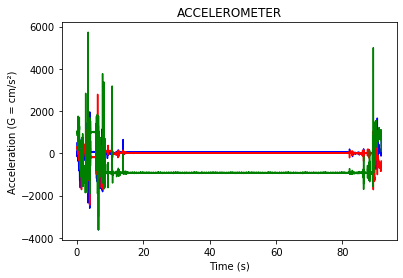

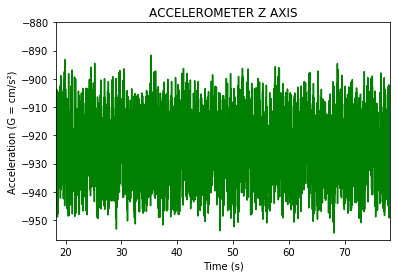

In [3]:
# 1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis.
# Pay attention on time rappresentation and the measurament unit.
# We have been told that the measurement unit the acceleration is represented is not m/s² (the one of the SI) but
# the Gal, which was named after Galileo Galilei and it is used to measure acceleration.

# Accelerometer plot
plt.plot(data1['Time'], data1['AccX'], 'b-', label = 'AccX')
plt.plot(data1['Time'], data1['AccY'], 'r-', label = 'AccY')
plt.plot(data1['Time'], data1['AccZ'], 'g-', label = 'AccZ')
plt.title("ACCELEROMETER")
plt.ylabel("Acceleration (G = cm/s²)")
plt.xlabel("Time (s)")
plt.show()

# Z axis plot
plt.plot(data1['Time'], data1['AccZ'], 'g-',label='AccZ')
plt.xlim([18.21, 78.21])
plt.ylim([-957, -880])
plt.title("ACCELEROMETER Z AXIS")
plt.ylabel("Acceleration (G = cm/s²)")
plt.xlabel("Time (s)")
plt.show()

**As we can see in the plot above, in both corners there is a high quantity of noise that we have to avoid. For that reason, the interval we are taking is (18.21, 78.21), which is 60 seconds long.**

In [4]:
# The interval selected is [18.21, 78.21] because regularity of the values is maintained so it is more reliable. 
# Trying to avoid noise
data1 = data1[(data1['Time'] >= 18.21) & (data1['Time'] <= 78.21)]

<font color='red'> 1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice. </font>

**In order to make a decision about over what axis should we do the analysis, we first need to calculate the different statistical measures.**

<font color='red'> 2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting  descriptors for this type of data, motivating the choices. </font>

**In order to calculate the different statistical descriptors, we can use the function *describe()* (provided by *pandas* and used for *DataFrames*) instead of calculate all the parameters by their own formulas; this method generates a table where the mean, standard deviation, minimum, maximum and percentiles of each parameter are saved.**

**Furthermore, to calculate the correlation coefficients between features the method *corr()* (provided by *pandas* and used for *DataFrames*) is used.**

In [5]:
# 2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical 
# descriptors includes for example mean, median, variance, standard deviation, 25th and 75th 
# percentiles, and correlation coefficients. Investigate what could be the most interesting 
# descriptors for this type of data, motivating the choices.

# Describe() functions extracts the statistical characteristics that we need.
data1_analysis = data1.describe()
data1_analysis = data1_analysis.rename(columns = {"Time": "Time (s)", "AccX": "AccX (G)", "AccY": "AccY (G)", "AccZ": "AccZ (G)"})

# Remove time column which does not make any sense in the table.
data1_analysis = data1_analysis.iloc[:, 1:]
# Corr() functions shows are if the features are correlated between them.
correlation_coefficients = data1_analysis.corr()
print("Statistical analysis: \n")
print(data1_analysis)
print("\nCorrelation coefficients: \n")
print(correlation_coefficients)

Statistical analysis: 

          AccX (G)     AccY (G)     AccZ (G)
count  6000.000000  6000.000000  6000.000000
mean     44.152847    21.566550  -924.190606
std       4.615788     2.972803     9.700034
min      26.535000     8.296000  -954.589000
25%      41.358000    19.642000  -929.152000
50%      44.164000    21.594000  -924.150000
75%      46.909000    23.485000  -919.026000
max      63.623000    33.672000  -891.637000

Correlation coefficients: 

          AccX (G)  AccY (G)  AccZ (G)
AccX (G)  1.000000  0.999992  0.989955
AccY (G)  0.999992  1.000000  0.990448
AccZ (G)  0.989955  0.990448  1.000000


**On the table above we can see some of the most important statistical measures, which are very useful to do a consistent analysis.**

**As we can see, axes *X* and *Y* are similar if we compare them to the *Z* axis, which has very different values. The most important characteristic that we have taken into account to choose the *Z* axis is that its mean (in *Gal*s) is very close to the acceleration that defines the gravity of the earth (g = -9.80665 m/s²); the mean is -924.190606 Gal, which is equal to -9.241906 m/s² (as 1 Gal = 1 cm/s² = 0.01 m/s²). Besides, if we have a look on the standard deviation of the *Z* axis we can see that it has a very high value, as it doubles the axis *X* and it quadriplies the axis *Y*.
The standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range.**

**Furthermore, we can see in the correlation coefficients that all features highly correlated (all over 0.98), which means that all variables all very related between them.**

**For all this reasons, we have decided that analyzing the *Z* axis of the accelerometer could be a good idea.**

<font color='red'> 2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.</font>

**The statistical analysis does not provide sufficient details about the respiration. It consists of required signal, but also of a noise that we want to avoid; therefore, a suitable processing technique is required to extract the signal. To calculate the respiration rate, we want to extract the maximas and calculate how much time takes going from one peak to another.**

In [6]:
# 2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum 
# and explain what you see. Use this step in order to properly design the filters 
# in the following step.

def fast_fourier_transform(y_values, T, N):
    f_values = np.linspace(0.0, 1.0/(2.0 * T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2]) 
    return f_values, fft_values

# Power Spectral Density indicates how is the power distributed regarding the frequency and it is required to find 
# the time window at which the maxima lies.
def power_spectral_density(y_values, f_s):
    f_values, psd_values = welch(y_values, fs = f_s)
    return f_values, psd_values

**In the cell above we have defined two different methods, one for getting the values obtained from the Fast Fourier Transform (using *fft()* method from *scipy.signal* library) and the second to obtain the Power Spectral Density using Welch's method.**

**A Fast Fourier transform (FFT) is an algorithm that computes the discrete Fourier transform (DFT) of a sequence. Fourier analysis converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.**

<img src = "figure1.png">

**Basically, the fast Fourier transformation takes a function which is a combination of simple sinusoidal waves and plots each simple wave's amplitude in the corresponding frequency. Like this, we can see which certain frequence(s) give meaningful information.**

**A Power Spectral Density (PSD) is the measure of signal's power content versus frequency. A PSD is typically used to characterize broadband random signals. The amplitude of the PSD is normalized by the spectral resolution employed to digitize the signal.
Welch's method, named after Peter D. Welch, is an approach for spectral density estimation. The method is based on the concept of using periodogram spectrum estimates, which are the result of converting a signal from the time domain to the frequency domain. Basically, we need it to to find the time window at which the maxima lies.**

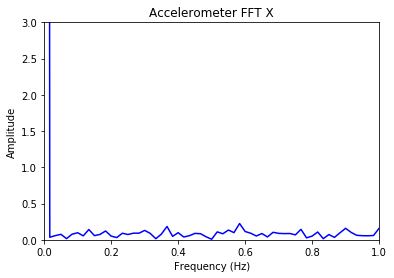

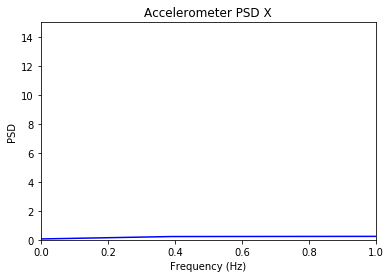

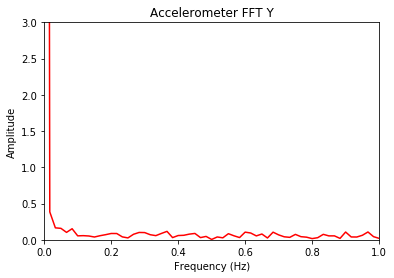

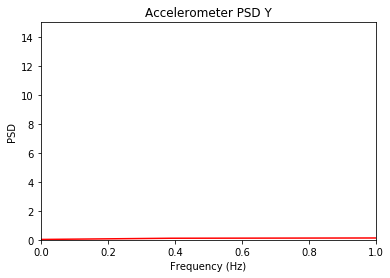

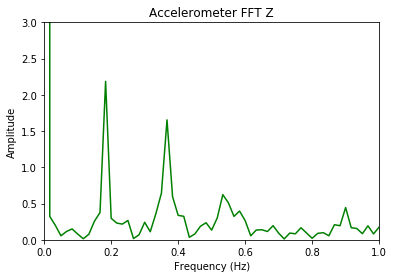

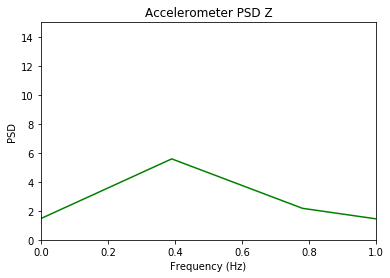

In [7]:
N = data1.shape[0]
T = 1/freq   
f_s = freq

# Spectrum plotted just for accelerometer, because gyroscope is not relevant.
# Gyroscope will not be able to be analyzed since the sensor is kept fixed and can not rotate.

f_values_x, fft_values_x = fast_fourier_transform(data1['AccX'], T, N)
f_values_psd_x, psd_values_x = power_spectral_density(data1['AccX'], f_s)

f_values_y, fft_values_y = fast_fourier_transform(data1['AccY'], T, N)
f_values_psd_y, psd_values_y = power_spectral_density(data1['AccY'], f_s)

f_values_z, fft_values_z = fast_fourier_transform(data1['AccZ'], T, N)
f_values_psd_z, psd_values_z = power_spectral_density(data1['AccZ'], f_s)

# Plot the fourier transformation and the power spectral density.

#AccX
plt.plot(f_values_x, fft_values_x, 'b')
plt.title("Accelerometer FFT X")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.axis([0, 1, 0, 3])
plt.show()

plt.plot(f_values_psd_x, psd_values_x, linestyle = '-', color = 'blue')
plt.title("Accelerometer PSD X")
plt.ylabel("PSD")
plt.xlabel("Frequency (Hz)")
plt.axis([0, 1, 0, 15])
plt.show()

#AccY
plt.plot(f_values_y, fft_values_y, 'r')
plt.title("Accelerometer FFT Y")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.axis([0, 1, 0, 3])
plt.show()

plt.plot(f_values_psd_y, psd_values_y, linestyle = '-', color = 'red')
plt.title("Accelerometer PSD Y")
plt.ylabel("PSD")
plt.xlabel("Frequency (Hz)")
plt.axis([0, 1, 0, 15])
plt.show()

#AccZ
plt.plot(f_values_z,fft_values_z, 'g')
plt.title("Accelerometer FFT Z")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.axis([0, 1, 0, 3])
plt.show()

plt.plot(f_values_psd_z, psd_values_z, linestyle = '-', color = 'green')
plt.title("Accelerometer PSD Z")
plt.ylabel("PSD")
plt.xlabel("Frequency (Hz)")
plt.axis([0, 1, 0, 15])
plt.show()

**Observing the plots above, first of all, since we are trying to estimate respiration rate, we are in frequencies lower than 1Hz so the frequency range of the plots is $[0,1]$. It is noticeable that axes *X* and *Y* of the accelerometer do not give any useful information because there is no any remarkable peak in their FFT plots. Things are different, however, for *Z* axis where two quite high peaks appear on frequencies $\sim 0.2$ and $\sim 0.4$. Same behaviour is perceived for PSD plots, where we barely see any minimum peak in the first two axes, but a noticeable extreme is obtained for *Z* axis, which is the maxima we are looking for.**

**After analysing the data both statistically and by *Fourier* transform, it results obvious to select axis *Z* for future analytics. The frequency band used for filtering the data is $[0.15,0.4]$ which coincides with the frequencies that extract the better information for us.**

# Filter

In [8]:
# Implement your own filter, trying to extrapolate respiratory rate signal.
# Butterworth filter, an Infinite Input Response.
def butterworth_filter(filter_order, frequency_in, filter_type, f_s, data_in):
    b,a = butter(filter_order, frequency_in, filter_type, fs = f_s)
    data_filtered = filtfilt(b, a, data_in)  
    return data_filtered

**After doing the Fourier analysis, we need to find a suitable filter to extract a single wave. By definition, a filter is a device or process that removes some unwanted components or features from a signal; most often, this means removing some frequencies or frequency bands.**

**We can separate the filters into different types, and the following three are the most important:**
    
    · Lowpass: allows low frequencies component lower than the cut off frequency to pass through and attenuates 
    others higher than the cut off frequency.
    · Bandpass: allows frequencies within a certain range and attenuate frequencies outside that range.
    · Highpass: allow high frequencies component above the cut off frequency to pass through and attenuate others 
    lower that the cut off frecuency.

<img src = "figure2.png">

**After that, we had to define a filter that better fitted with our data; for this reason, we have tried with some different *IIR* (Infinite Input Response) filters, such as *Chebyshev*, *Elliptic*, *Bessel*... but none of them works as good as the filter called *Butterworth*, which is designed to have a frequency response as flat as possible in the passband. By definition, an *IIR* filter is a digital filter that depends linearly on a finite number of input samples and a finite number of previous filter outputs; there is no a perfect *IIR* filter, as each filter is good in some areas but poor in others; for example, in the case of Butterworth, it has the flattest pass-band but a poor roll-off rate. The aspect of the signal changes with the filter order, as we can see on the following figure:**

<img src = "figure3.png">

**The function receive as input 5 different parameters:**

    · filter_order: the order of the filter, which is the degree of the approximating polynomial.
    · frecuency_in: the frecuency range that we want to allow.
    · filter_type: the type of the filter; in our case, "band" (bandpass).
    · f_s: the frecuency that is get from the initial data; in our case, 100.
    · data_in: the data of the signal.

**First we use the *butter* function, which returns the numerator (b) and denominator (a) polynomials of the filter. After that, we use the *filtfilt* function in order to apply a digital filter forward and backward to the signal, using as input the numerator and denominator coefficient vectors that we got in the previous step. *filtfilt* is zero-phase filtering, which doesn't shift the signal as it filters. Since the phase is zero at all frequencies, it is also linear-phase, as is it shown in the following image.**

<img src = "figure4.png">

**We calculate the mean of the *Z* axis because we will need it to plot the following figures.**

In [9]:
# Compute mean accelerometer's z axis, which is the only one used for further analysis
mean_amplitude_AccZ = data1[['AccZ']].mean()[0]

**We use the bandpass butterworth filter of 3rd order, and the frecuency range used is (0.15, 0.4) as it is explained before. After that, we have plotted the filtered signal, obtaining a result where we can observe how the respiration is represented by the filtered signal.**

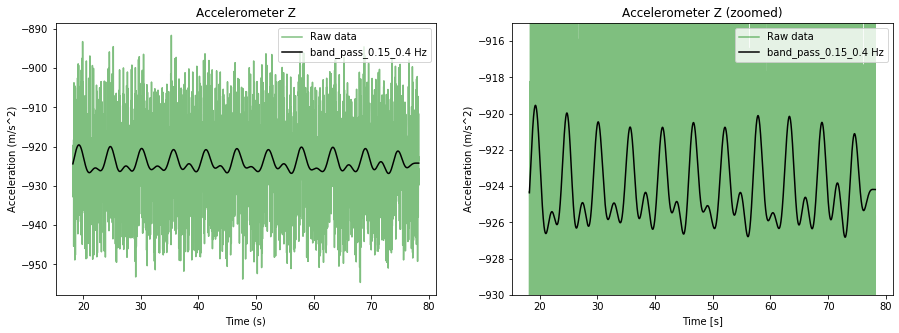

In [10]:
# Apply butterworth filter
data_filtered = butterworth_filter(3, [0.15, 0.4], 'band', 100, data1['AccZ'])

# Plot raw data and filtered data
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(data1['Time'], data1['AccZ'], 'g', alpha = 0.5, label = 'Raw data')
axs[0].plot(data1['Time'], data_filtered + mean_amplitude_AccZ, 'k', label = 'band_pass_0.15_0.4 Hz')
axs[0].set_title('Accelerometer Z')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].set_xlabel('Time (s)')
axs[0].legend(loc = 1)

axs[1].plot(data1['Time'], data1['AccZ'], 'g', alpha = 0.5, label = 'Raw data')
axs[1].plot(data1['Time'], data_filtered + mean_amplitude_AccZ, 'k', label = 'band_pass_0.15_0.4 Hz')
axs[1].set_title('Accelerometer Z (zoomed)')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylim([-930, -915])
axs[1].legend(loc = 1)

# Hilbert transform

**By applying the *Hilbert* transform to a filtered signal we convert a real - valued signal into a complex - valued signal, and the result we get is analogous to the result of *complex Morlet wavelet convolution* that is mentioned on the statement, as it is shown on the folloming image:**

<img src = "figure7.png">

**Furthermore, another interesting information that we can get from the transform are the magnitude and the phase; the magnitude is what we are really interested in, as it can be used as an envelope for our signal and we can easily extract the maximas of the peaks from it. The envelope thus generalizes the concept of a constant amplitude into an instantaneous amplitude, which has turned out to be really useful. To calculate the envelope, we only need to calculate the absolute values of the transform:**

<img src = "figure8.png">

**For this, *pandas* provides the *hilbert()* function, used to apply that certain trasform. After that, we only need to use the *abs()* function and plot the result.**

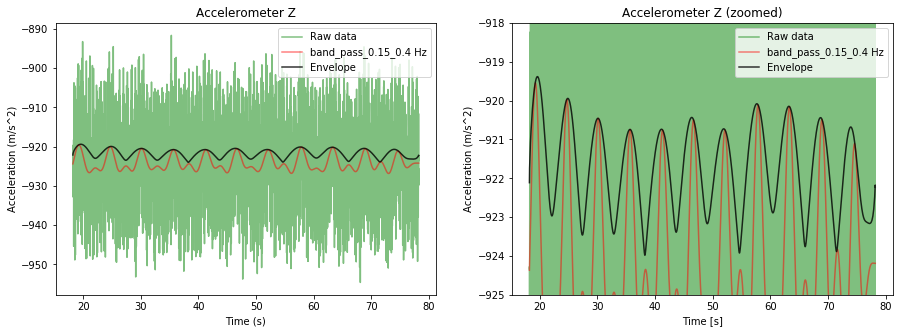

In [11]:
# Apply hilbert transform to the filtered signal and plot the envelope function, instantenous amplitude
hilbert_transform = hilbert(data_filtered)
envelope_amplitude = np.abs(hilbert_transform)

# Plot raw data and the envelope
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(data1['Time'], data1['AccZ'], 'g', alpha = 0.5, label = 'Raw data')
axs[0].plot(data1['Time'], data_filtered + mean_amplitude_AccZ, 'r', alpha = 0.5, label = 'band_pass_0.15_0.4 Hz')
axs[0].plot(data1['Time'], envelope_amplitude + mean_amplitude_AccZ, 'k', alpha = 0.8, label = 'Envelope')
axs[0].set_title('Accelerometer Z')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].set_xlabel('Time (s)')
axs[0].legend(loc = 1)

axs[1].plot(data1['Time'], data1['AccZ'], 'g', alpha = 0.5, label = 'Raw data')
axs[1].plot(data1['Time'], data_filtered + mean_amplitude_AccZ, 'r', alpha = 0.5, label = 'band_pass_0.15_0.4 Hz')
axs[1].plot(data1['Time'], envelope_amplitude + mean_amplitude_AccZ, 'k', alpha = 0.8, label = 'Envelope')
axs[1].set_title('Accelerometer Z (zoomed)')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylim([-925, -918])
axs[1].legend(loc = 1)

**Looking at the images obtained in the cell above, we can observe that the function goes from the amplitude of a wave to the amplitude of the next one. The center of a single wave packet is extracted, which periodically shows up.**

# Relative maximum

**Once the envelope function has been used in order to trace the extremes of the signal, the relative maxima of this function need to be computed because the assumption we have made is that each relative maximum belongs to a different respiration. Obtaining the exact time within the minute for each relative maximum is the key in order to estimate the breaths per minute. That is why we have implemented the *find_max()* function. *pandas* provides the *argrelextrema()* function which gives the possibility to obtain an array of just indices of the relative maxima. Then, after applying the *iloc()* function, the 'max' column is added to the Dataframe, where if in a certain time there is no a maximum, it is filled with "NaN".**

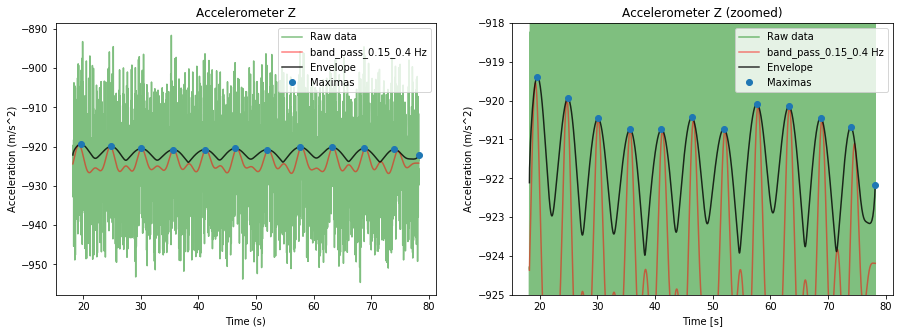

In [12]:
# Difference between two high peaks is the period in seconds, used in order to achieve rpm
def find_max(time, filtered_data):
    filterData = pd.DataFrame({'Time': time, 'Filtered': filtered_data})
    filterData['max'] = filterData.iloc[argrelextrema(filterData.Filtered.values, np.greater_equal, order = 10)[0]]['Filtered']
    return filterData

envelope_max = find_max(data1['Time'].values, envelope_amplitude + mean_amplitude_AccZ)

# Plot relative maximums
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(data1['Time'], data1['AccZ'], 'g', alpha = 0.5, label = 'Raw data')
axs[0].plot(data1['Time'], data_filtered + mean_amplitude_AccZ, 'r', alpha = 0.5, label = 'band_pass_0.15_0.4 Hz')
axs[0].plot(data1['Time'], envelope_amplitude + mean_amplitude_AccZ, 'k', alpha = 0.8, label = 'Envelope')
axs[0].plot(data1['Time'], envelope_max['max'], 'o', label = 'Maximas')
axs[0].set_title('Accelerometer Z')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].set_xlabel('Time (s)')
axs[0].legend(loc = 1)

axs[1].plot(data1['Time'], data1['AccZ'], 'g', alpha = 0.5, label = 'Raw data')
axs[1].plot(data1['Time'], data_filtered + mean_amplitude_AccZ, 'r', alpha = 0.5, label = 'band_pass_0.15_0.4 Hz')
axs[1].plot(data1['Time'], envelope_amplitude + mean_amplitude_AccZ,'k', alpha = 0.8, label = 'Envelope')
axs[1].plot(data1['Time'], envelope_max['max'], 'o', label = 'Maximas')
axs[1].set_title('Accelerometer Z (zoomed)')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylim([-925, -918])
axs[1].legend(loc = 1)

**As we can see on the plots, after slicing the data obtained by printing just the maxima, we can observe that the algorithm has found a relative maxima on each of the 12 peaks, meaning that there have been 12 breathing in set time interval (one minute). However, the last maxima is not following the regular breathing that we can observe on the previous breaths, since it is done a bit faster as we will explain in the following section.**

# Metrics

<font color='red'> 4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, make an histogram of the result. Does it follow a partiular distribution? </font>

# Time difference between peaks

**In order to obtain the BPM estimation, the time difference between the respective peaks of the envelope function needs to be obtained. Having every difference permits to obtain the mean, which will give us what we are looking for. The *time_diff()* function has been implemented for that, taking advantage of the *diff()* function provided by *pandas* which computes the difference between the current row and the one before. As we are interested in every peak, the values of those do not have to be limited. However, as the are many rows with no 'max' value, a *None* value will fill that cell so the *dropna()* function helps to remove those rows.**

In [13]:
# Plot distances between respective peaks
def time_diff(df_filter):
    array_time_max = df_filter[['Time', 'max']]
    best_value = array_time_max[(array_time_max['max'] > -922.5)] 
    difference = best_value.diff()
    difference = difference.abs()
    return difference.dropna()

time_differences = time_diff(envelope_max)
print(time_differences)

      Time       max
666   5.26  0.561452
1189  5.23  0.512733
1744  5.55  0.286802
2291  5.47  0.005263
2815  5.24  0.303764
3370  5.55  0.293654
3944  5.74  0.646027
4500  5.56  0.065544
5050  5.50  0.291952
5574  5.24  0.240963
5998  4.24  1.495419


**We can appreciate that all the values are more or less in the same range (5,6), except the last one which has a much lower value: 4.24. This can also be observed on the plot above, where the last peak is above the other ones, making this last breath faster than the other ones.**

**This may have happened for two reasons:**

    · During the last breath the signal has been hitten by noise and the information we are processing is not totally correct
    · A slight disturbance has occurred in the last breath,making the patient breath faster than before, skipping the regularity we have obtained previously.
    

# Average time between breaths and its standard deviation

**Now we are calculating how much time passes between two breaths and check if the values are close or far from the mean with the standard deviation.**

In [14]:
final_mean = np.mean(time_differences['Time'].values)
final_std = np.std(time_differences['Time'].values)

print("Average time between two breaths:", final_mean)
print("Standard deviation", final_std)

Average time between two breaths: 5.325454545454545
Standard deviation 0.3796257400115801


**As we can see, a breath is done in average every 5.32 seconds and the values we have got on the analysis are really close from the mean as the standard deviation is very low (0.37).**

# RPM (Respiration Rate Per Minute) and its standard deviation

**Calculating the RPM is an easy task once we have the breathing average; we only need to decide the time interval (in our case, a minute = 60 seconds) and divide it by the mean.**

**After that, it is interesting to calculate the standard deviation of the RPM, in order to know if the values we got are close from the RPM; for that, we know that the relation between RPM and average time between respirations is $f(x) = \dfrac{60}{x}$ where x is the mean of time between respirations. Error propagation needs to be taken into account so the uncertainty of the RPM is computed as follows: $\delta f = \dfrac{df}{dx} \cdot \delta x$ where $\delta x$ is the standard deviation of average time between respirations.**
$$\delta f = \dfrac{60}{5.325^2} \cdot 0.379 = 0.8$$

In [15]:
RPM = 60 / final_mean
std_RPM = (60/(final_mean)**2) * final_std
print('RPM:', RPM)
print('The std of RPM:', std_RPM)

RPM: 11.266643905769888
The std of RPM: 0.8031442187081492


**As a result, we got that the RPM is 11.26 and its standard deviation is 0.8, which leads to:**
    
    · Lower bound -> 11.26 - 0.8 = 10.46
    · Upper bound -> 11.26 + 0.8 = 12.06
    
**After that, we have tried to find on the Internet reliable webpages where it is shown which should be the value of the the RPM on a healthy adult subject while resting. In *Medline Plus*, an online information service produced by the United States National Library of Medicine, it is explained that the RPM should be between 8 and 16, being 12 the optimal value (https://medlineplus.gov/ency/article/007198.htm).**

<img src = "figure5.png">

<img src = "figure6.png">

**So, taking all this in account, we think that the approximation we have got (11.26 breaths per minute) is good enough to use it as our final result.**

# Skewness and kurtosis

***Skewness* and *kurtosis* are two statistical measures that give us important information about our distribution:**

    · Skewness: Skewness is a measure of the degree of asymmetry of a distribution. If the left tail (tail at small end of the distribution) is more pronounced than the right tail (tail at the large end of the distribution), the function is said to have negative skewness. If the reverse is true, it has positive skewness. If the two are equal, it has zero skewness.
    · Kurtosis: Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values.

In [16]:
from scipy.stats import skew, kurtosis

skewness = skew(time_differences['Time'], axis = 0)
kurtosis = kurtosis(time_differences['Time'], axis = 0)

print('Skewness:', skewness)
print('Kurtosis:', kurtosis)

Skewness: -1.9377710038404992
Kurtosis: 3.2478372504394075


**The *skewness* we get is negative, meaning that the distribution is not symetric and most of the values are located on the final of it.**

**In the case of the *kurtosis*, as it is positive, we can find out that the distribution is peaked and possess thick tails.**

# The histogram

**A histogram is an approximate representation of the distribution of numerical or categorical data. In our case, we want to represent how are the breaths distributed through the time; for that, the extrapolated respiration rate estimation is plotted into a histogram regarding the time difference between respective peaks. The number of bins used has been 5 due to the fact that if we look at the differences, they are pretty close to each other, mostly.**

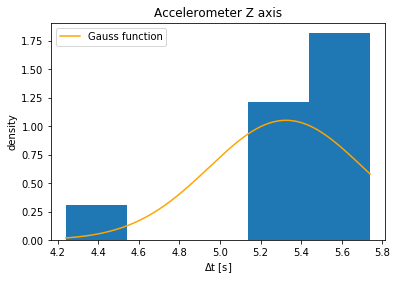

In [17]:
(g_mean, g_std) = norm.fit(time_differences['Time'].values)
gaussian_distribution = norm(loc = g_mean, scale = g_std) 

g = np.arange(min(min(time_differences['Time'].values), min(time_differences['Time'].values)), 
              max(max(time_differences['Time'].values), max(time_differences['Time'].values)) + 0.01, 0.01)

plt.hist(time_differences['Time'].values, bins = 5, density = True)
plt.plot(g, gaussian_distribution.pdf(g), color = 'orange', label = "Gauss function")
plt.title("Accelerometer Z axis")
plt.xlabel("$\Delta$t [s]")
plt.ylabel("density")
plt.legend()
plt.show()

**Two different things have been plotted on the figure: first, the histogram itself; and second, the hypothetical gaussian distribution, which does not really fit with the histogram. We have tried also with other different distributions, such as chi square, binomial or Poisson; however, our histogram does not follow any of them because of the last breath (which lasts 4.24 seconds), which appears at the beginning of the histogram and gives a rare shape to the histogram. Just in case, if we delete that last breath, we would get an histogram that may follow one of that distributions (chi square, maybe).**

**The *skewness* has a value of $-1.937 > 0$, indicating that the histogram is not symmetric and that most of the time differences are concentrated on the right side of the histogram. Only one difference is located on the left side, the value regarding the last breath, $4.24$ seconds, quite remarkable, lowering the average time difference between respirations and getting a worst BPM estimation. The mean of the time distribution is $5.32$ seconds and its standard deviation is of $0.379$, so most of the values are within the range of $5.32 \pm 0.379$ seconds.**

**Due to the fact of what mentioned before, the estimated average BPM obtained is $11.266$ and its standard deviation $0.803$. We already know, as explained above, that the number of times an adult breaths when resting is about 12, which we approximately expected to obtain. Being every value except one concentrated in a small range of the histogram seems logical to us, since the time between respiration tends to be regular when resting.**

<font color='red'> 4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results. </font>

# Respiration rate variability

**The respiration rate variability, also known as *RRV*, is the physiological phenomenon of variation in the time interval between breaths. It is measured by the variation in the breath-to-breath interval. By the application of this we analyse how the time between respective high peaks change along one minute. For instance, the histogram plotted before gives us an idea of this concept, since the densities for time between peaks are computed. However, the relation between respective peaks has been not taken into account, which is shown in the following cell.**

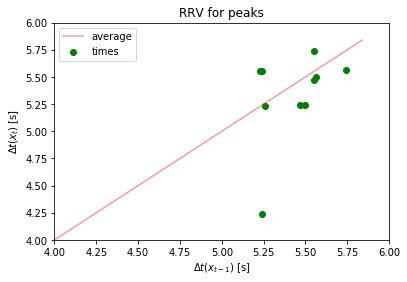

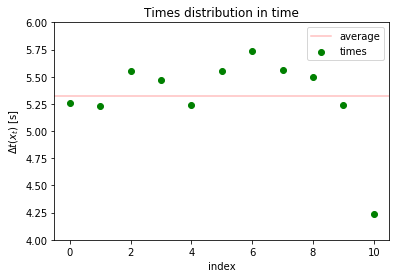

In [18]:
x = np.linspace(0.2, max(time_differences['Time']) + 0.1 , 100)

plt.scatter(time_differences['Time'].values[:-1], time_differences['Time'].values[1:], color = 'g', label = "times")
plt.title("RRV for peaks")
plt.xlabel("$\Delta t (x_{t-1})$ [s]")
plt.ylabel("$\Delta t (x_{t})$ [s]")
plt.plot(x, x, alpha = 0.4, label = 'average', color = "red")
plt.xlim([4, 6])
plt.ylim([4, 6])
plt.legend()
plt.plot()
plt.show()


plt.scatter(np.arange(len(time_differences['Time'].values)), time_differences['Time'].values, color = 'g', label = "times")
plt.axhline(final_mean, color = "red", alpha = 0.25, label = 'average')
plt.title("Times distribution in time")
plt.xlabel("index")
plt.ylabel("$\Delta t (x_{t})$ [s]")
plt.ylim([4, 6])
plt.legend()
plt.plot()
plt.show()

**What this *scatter* plot tells us is, that respective peaks follow a decent linear relation. In other words, $\Delta x_{t-1}$ and $\Delta x_t$ are quite similar, mostly within the range $[5.25, 5.75]$. Since the subject is lying on the matress, in a period of rest, it is obvious that the time between respirations is close to be a constant, a sign of relaxation. This type of respiration rate is called *eupnea*, where neural output to respiratory muscles is highly regular. Nevertheless, there is an exception in the RRV plot, in particular the last breath,$t_{12}$ which starts after $4.25$ seconds after the $t_{11}$. Regarding the plots of the beginning, the most logical cause to happening this is the fact that the noise alters the signal, giving a unexpected result.**

**As for analysing $\Delta x_ {t}$'s relation to the average $\Delta x_t$, again a similar behaviour to the RRV plot is observed, where every breath except for the last one is quite similar to the average as a result of *resting respiratory rate*. As a consequence, the average value of the time between respective peaks lowers, obtaining a unwanted estimation of the respiration rate, as the average is not located on the bin with highest density of the histogram. In case there is any way to make noise have less impact, this unfortunate case like $t_{12}$ would not be noticed.**